## Load Packages

In [1]:
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Concatenate, Conv2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0 as BaseModel
from tensorflow.keras.applications.efficientnet import preprocess_input
from one_hot_encoder import one_hot_encode_sex, one_hot_encode_localization, one_hot_encode_dx

sex ['female', 'male', 'unknown']
localization ['abdomen', 'acral', 'back', 'chest', 'ear', 'face', 'foot', 'genital', 'hand', 'lower extremity', 'neck', 'scalp', 'trunk', 'unknown', 'upper extremity']
dx ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


## Constants

In [2]:
N_CLASSES_PREDICTOR = 7

# [age, sex, localization]
N_DIM_AGE = 1
N_DIM_SEX = 3
N_DIM_LOCALIZATION = 15
BATCH_SIZE = 16
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
IMAGE_CHANNELS = 3

## Create Model

In [3]:
# Define two input layers
image_input = Input((IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))

# 1. AGE INPUT
age_input = Input((N_DIM_AGE))

# 2. SEX INPUT
sex_input = Input((N_DIM_SEX))

# 3. LOCALIZATION INPUT
localization_input = Input((N_DIM_LOCALIZATION))

# 4. IMAGE INPUT: Convolution + Flatten for the image
base_model = BaseModel(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))
base_model.trainable = False

conv_layer = base_model(image_input)
conv_input = GlobalAveragePooling2D()(conv_layer)

# Concatenate the convolutional features and the vector input
concat_layer = Concatenate()([age_input, sex_input, localization_input, conv_input])
cl_layer1 = Dense(64, activation="relu")(concat_layer)
cl_layer2 = Dense(64, activation="relu")(cl_layer1)
output = Dense(N_CLASSES_PREDICTOR, activation="softmax")(cl_layer2)

# define a model with a list of two inputs
model = Model(inputs=[age_input, sex_input, localization_input, image_input], outputs=output)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

Metal device set to: Apple M1 Max


2022-11-13 15:49:20.190305: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-13 15:49:20.190423: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 efficientnetb0 (Functional)    (None, 7, 7, 1280)   4049571     ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 3)]          0           []                           

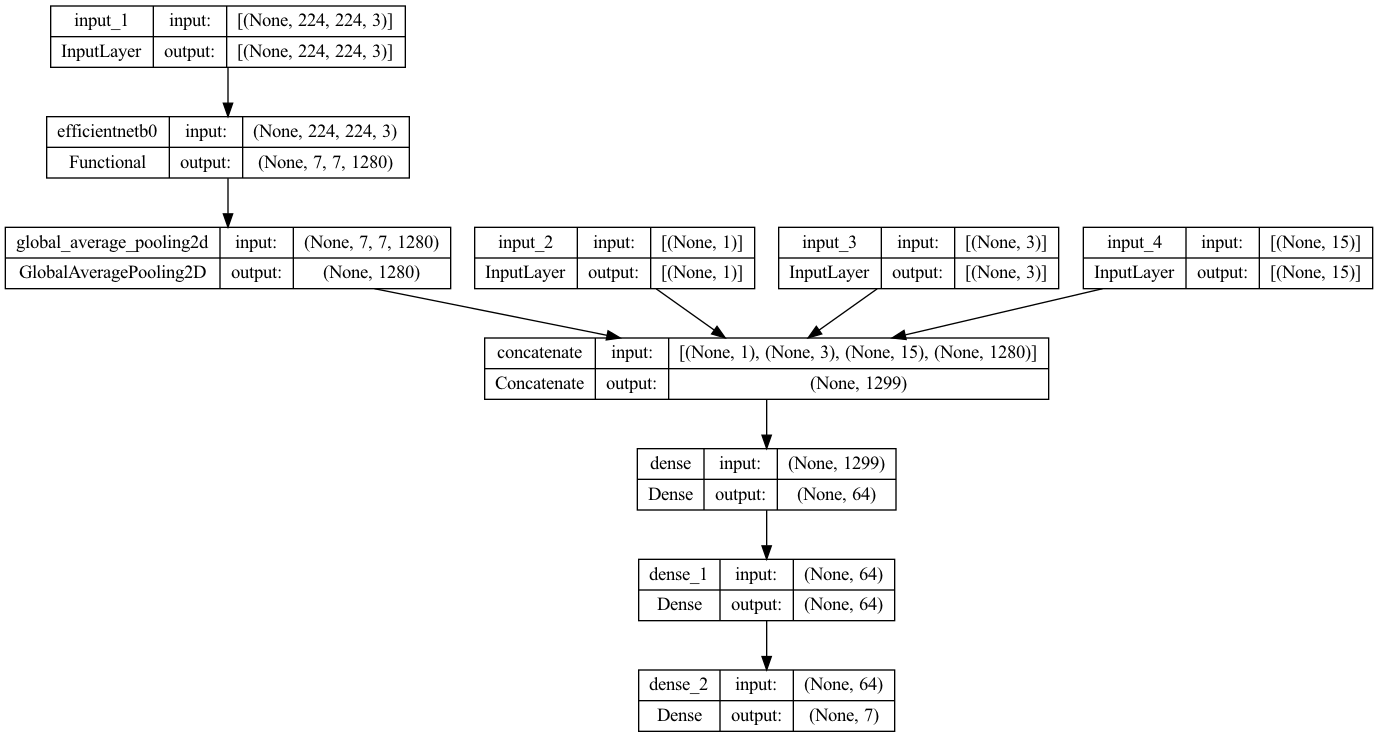

In [5]:
dot_img_file = 'model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [6]:
model.predict([np.zeros((1, N_DIM_AGE)), np.zeros((1, N_DIM_SEX)), np.zeros((1, N_DIM_LOCALIZATION)), np.zeros((1, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))])

2022-11-13 15:49:22.174654: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-13 15:49:22.624312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step


array([[0.10534239, 0.16707711, 0.18000609, 0.1186835 , 0.17417054,
        0.14791523, 0.10680518]], dtype=float32)

## Create Data Generator

In [7]:
train_df = pd.read_csv("train.csv", delimiter=";")
validation_df = pd.read_csv("validation.csv", delimiter=";")

In [8]:
class Generator(tf.keras.utils.Sequence):

    def __init__(self, df, X_col, y_col, batch_size, input_size, shuffle=True):
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        self.data_generator_size = len(self.df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
            
    def __get_image(self, image_id):
        image = tf.keras.preprocessing.image.load_img("dataset/"+image_id+".jpg")
        image_arr = tf.keras.preprocessing.image.img_to_array(image)
        image_arr = tf.image.resize(image_arr, [IMAGE_HEIGHT, IMAGE_WIDTH], antialias=True, method="bicubic")
        image_arr = preprocess_input(image_arr)
        return image_arr

    def __get_input(self, image_id_batch):
        image_batch = np.array([self.__get_image(image_id) for image_id in image_id_batch]).reshape(BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)
        age_batch = np.array([self.df.loc[self.df['image_id'] == image_id].age.values[0] for image_id in image_id_batch]).reshape(BATCH_SIZE, 1)
        sex_batch = np.array([one_hot_encode_sex(self.df.loc[self.df['image_id'] == image_id].sex.values[0]) for image_id in image_id_batch]).reshape(BATCH_SIZE, 3)
        localization_batch = np.array([one_hot_encode_localization(self.df.loc[self.df['image_id'] == image_id].localization.values[0]) for image_id in image_id_batch]).reshape(BATCH_SIZE, 15)

        return [age_batch,
                sex_batch, 
                localization_batch,
                image_batch]

    def __get_output(self, label, num_classes):
        return one_hot_encode_dx(label)

    def __get_data(self, batches):
        image_id_batch = batches[self.X_col]
        label_batch = batches[self.y_col]
        
        X_batch = self.__get_input(list(image_id_batch))
        y0_batch = np.asarray([self.__get_output(y, N_CLASSES_PREDICTOR) for y in label_batch])

        return X_batch, y0_batch

    def __getitem__(self, index):
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(batches)
        return X, y

    def __len__(self):
        return self.data_generator_size // self.batch_size

In [9]:
train_generator = Generator(train_df, X_col="image_id", y_col="dx", batch_size = BATCH_SIZE, input_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
validation_generator = Generator(validation_df, X_col="image_id", y_col="dx", batch_size = BATCH_SIZE, input_size=(IMAGE_HEIGHT, IMAGE_WIDTH))

In [10]:
for bt in train_generator:
    print(bt[0][0][0].shape, bt[1].shape)
    break

(1,) (16, 7)


In [11]:
history = model.fit(train_generator, epochs=1, verbose=1, validation_data=validation_generator)

2022-11-13 15:49:25.837770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


500/500 [==============================] - ETA: 0s - loss: 1.3435 - accuracy: 0.6680

2022-11-13 15:51:56.443941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


500/500 [==============================] - 170s 335ms/step - loss: 1.3435 - accuracy: 0.6680 - val_loss: 1.1417 - val_accuracy: 0.6683


In [26]:
for bt in validation_generator:
    print(model.predict(bt[0]))
    break

1/1 [==============================] - 0s 32ms/step
[[0.03579231 0.04829518 0.10579641 0.0181054  0.1058634  0.66257095
  0.02357635]
 [0.03579231 0.04829518 0.10579641 0.0181054  0.1058634  0.66257095
  0.02357635]
 [0.03579231 0.04829518 0.10579641 0.0181054  0.1058634  0.66257095
  0.02357635]
 [0.03579231 0.04829518 0.10579641 0.0181054  0.1058634  0.66257095
  0.02357635]
 [0.03579231 0.04829518 0.10579641 0.0181054  0.1058634  0.66257095
  0.02357635]
 [0.03579231 0.04829518 0.10579641 0.0181054  0.1058634  0.66257095
  0.02357635]
 [0.03579231 0.04829518 0.10579641 0.0181054  0.1058634  0.66257095
  0.02357635]
 [0.03579231 0.04829518 0.10579641 0.0181054  0.1058634  0.66257095
  0.02357635]
 [0.03579231 0.04829518 0.10579641 0.0181054  0.1058634  0.66257095
  0.02357635]
 [0.03579231 0.04829518 0.10579641 0.0181054  0.1058634  0.66257095
  0.02357635]
 [0.03579231 0.04829518 0.10579641 0.0181054  0.1058634  0.66257095
  0.02357635]
 [0.03579231 0.04829518 0.10579641 0.0181054  